In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import statsmodels.api as sm
import statsmodels
import os

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from datetime import datetime, timedelta
from tqdm import tqdm
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

/home/kirill/projects/personal_projects/A1_10_22/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Functions, classes and etc

In [4]:
def SEED_EVERYTHING(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# EDA

In [5]:
PROJ_PATH = '/home/kirill/projects/personal_projects/A1_10_22/'
DATA_PATH = '/home/kirill/data/A1/'
csv_path = DATA_PATH + 'Задания_1_2.xlsx'

train_df = pd.read_excel(csv_path, sheet_name='Timeseries')
train_c_df = train_df.copy()

RAND_SEED = 42
SEED_EVERYTHING(RAND_SEED)

### Initial view

In [6]:
train_df

,Date,series1
0,2015-01-01,1006.699649
1,2015-01-02,3197.751826
2,2015-01-03,3217.491035
3,2015-01-04,2151.573759
4,2015-01-05,4243.929892
...,...,...
1637,2019-06-26,4007.059387
1638,2019-06-27,4836.106157
1639,2019-06-28,4895.323783
1640,2019-06-29,4086.016222


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     1642 non-null   object 
 1   series1  1642 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.8+ KB


In [12]:
first_row, last_row = train_df.iloc[0], train_df.iloc[-1]
print(f"First row:\n {first_row}")
print(f"\nLast row:\n {last_row}")

First row:
 Date        2015-01-01
series1    1006.699649
Name: 0, dtype: object

Last row:
 Date        2019-06-30
series1    3572.796793
Name: 1641, dtype: object


### Target statistics

In [8]:
train_df.describe()

,series1
count,1642.000000
mean,3854.975154
std,1237.337605
min,236.870506
25%,3138.534200
50%,3632.014420
75%,4258.734299
max,12652.832842


### Data has duplicates or missing values?

In [7]:
print("Number of duplicates in series1: ")
print(train_df.duplicated().sum())

Number of duplicates in series1: 
0


In [30]:
date_range = pd.date_range(train_df.iloc[0]['Date'], train_df.iloc[-1]['Date'], freq='1d')
date_range = [datetime.strftime(d, '%Y-%m-%d') for d in date_range]
date_range_train = train_df['Date'].tolist()

range_diff = set(date_range).difference(date_range_train)
print(f"Missing dates: {range_diff}, len: {len(range_diff)}")

Missing dates: set(), len: 0


### Visualize timeseries. All/month/week

<AxesSubplot:xlabel='Date', ylabel='series1'>

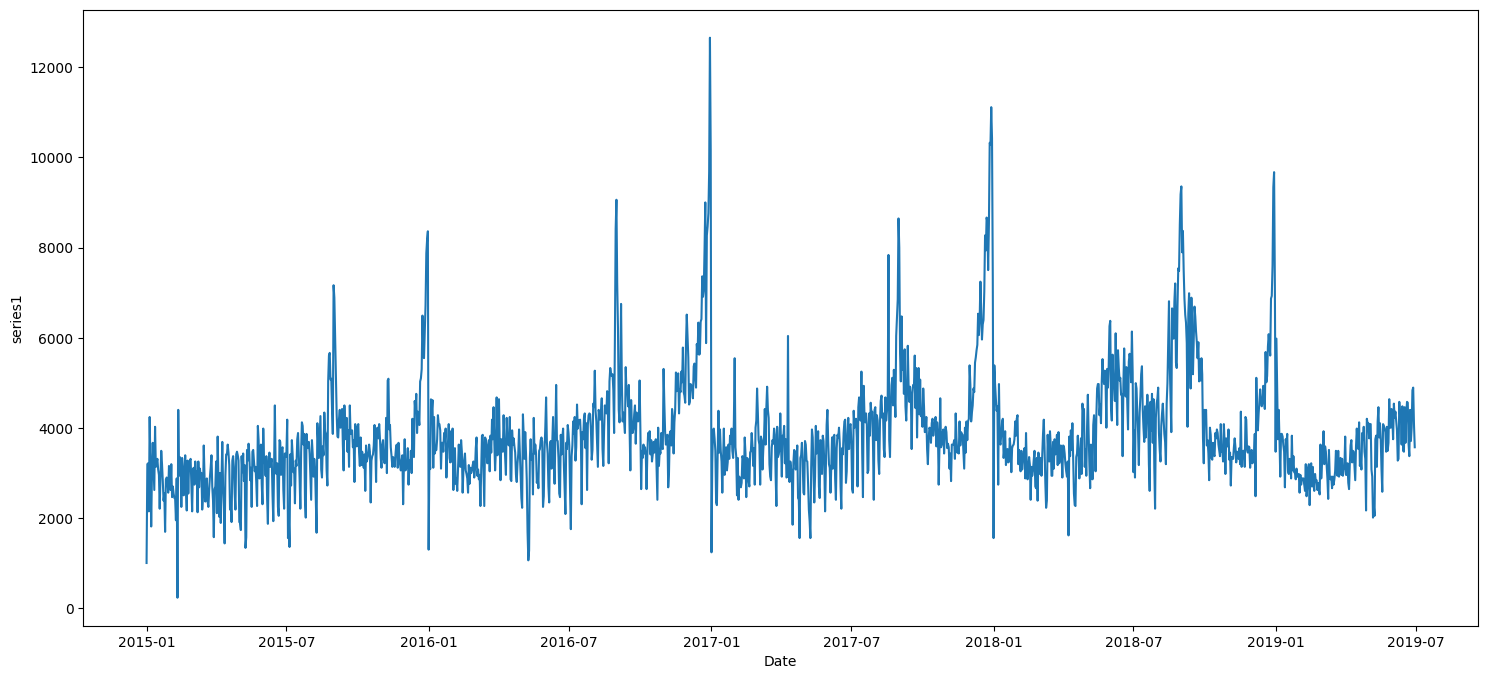

In [35]:
_, axs = plt.subplots(figsize=(18, 8))

train_c_df['Date'] = pd.to_datetime(train_c_df['Date'])
sns.lineplot(train_c_df, x='Date', y='series1', ax=axs)

<AxesSubplot:xlabel='Date', ylabel='series1'>

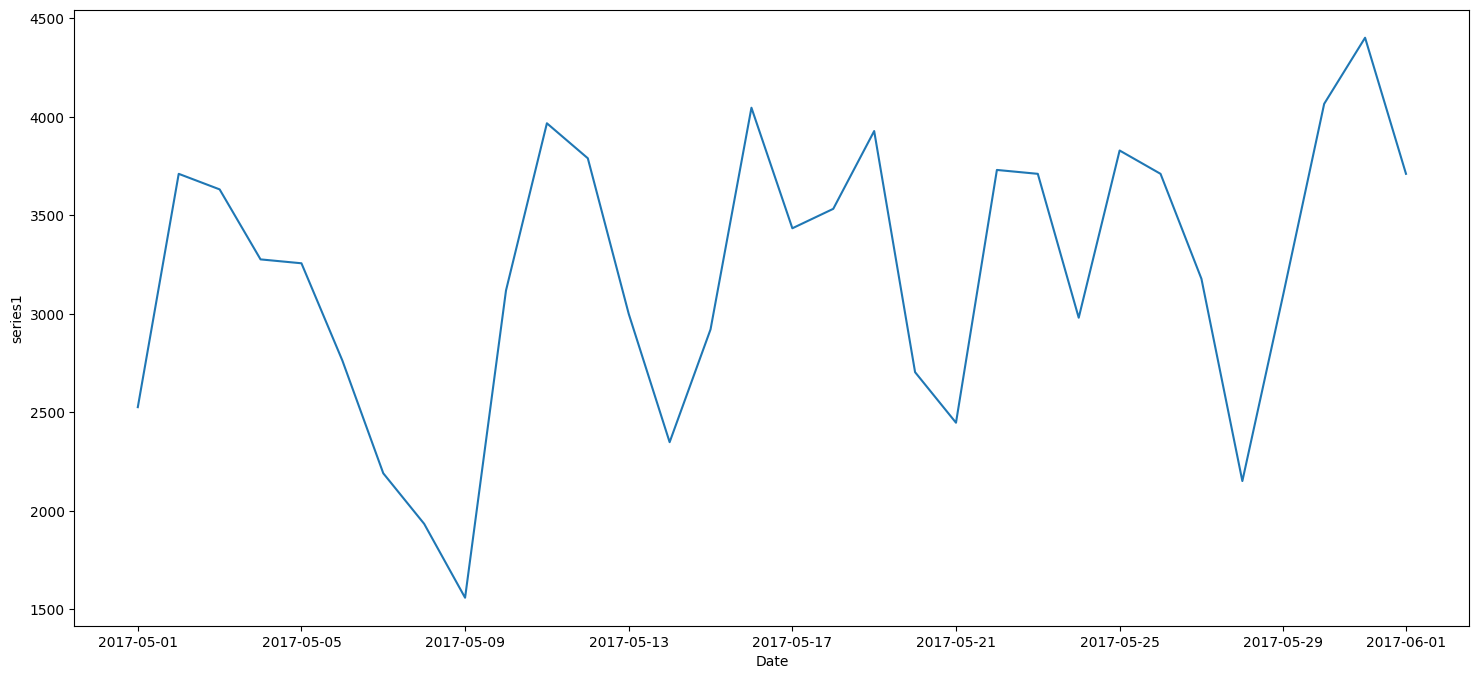

In [53]:
_, axs = plt.subplots(figsize=(18, 8))

start, end = '2017-05-01', '2017-06-01'

sns.lineplot(train_c_df[(train_c_df['Date'] >= start) & (train_c_df['Date'] <= end)], x='Date', y='series1', ax=axs)

<AxesSubplot:xlabel='Date', ylabel='series1'>

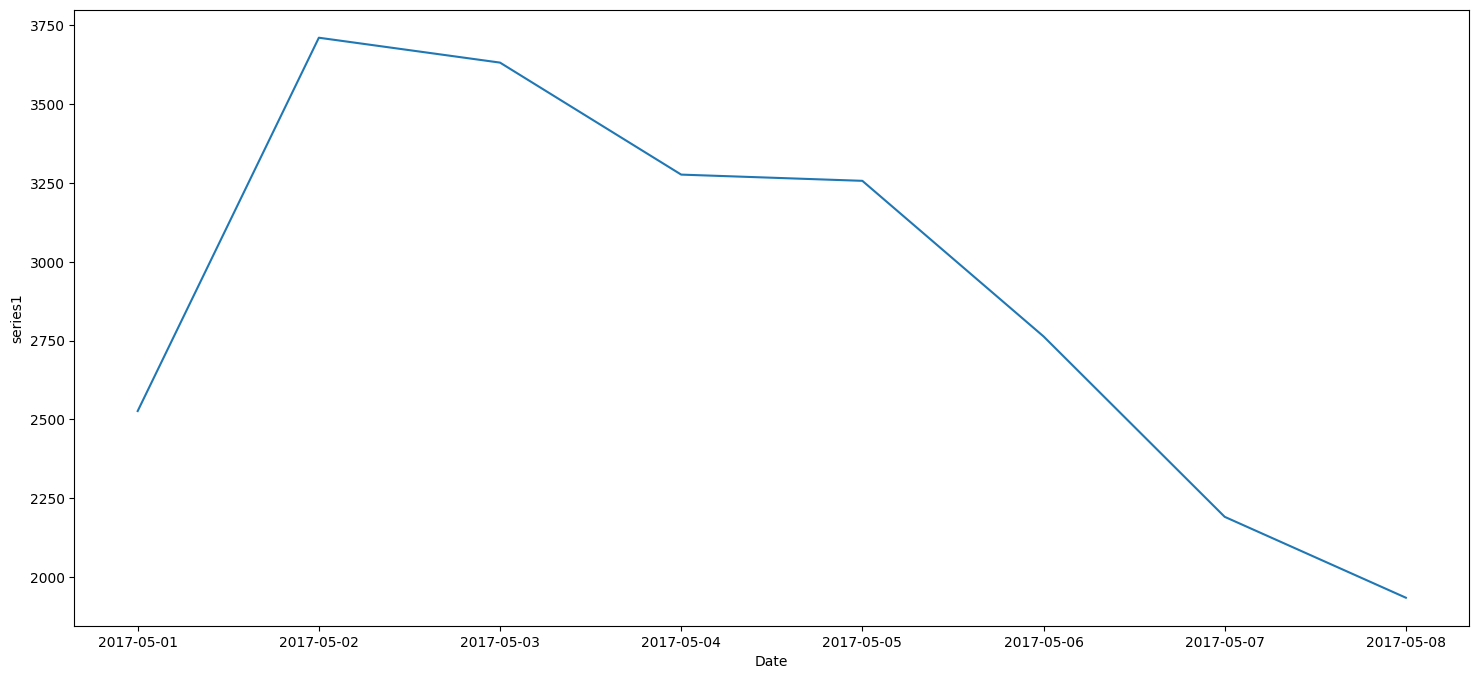

In [52]:
_, axs = plt.subplots(figsize=(18, 8))

start, end = '2017-05-01', '2017-05-08'

sns.lineplot(train_c_df[(train_c_df['Date'] >= start) & (train_c_df['Date'] <= end)], x='Date', y='series1', ax=axs)

### Trend / seasonal decomposition (additive / multiplicative)

<AxesSubplot:>

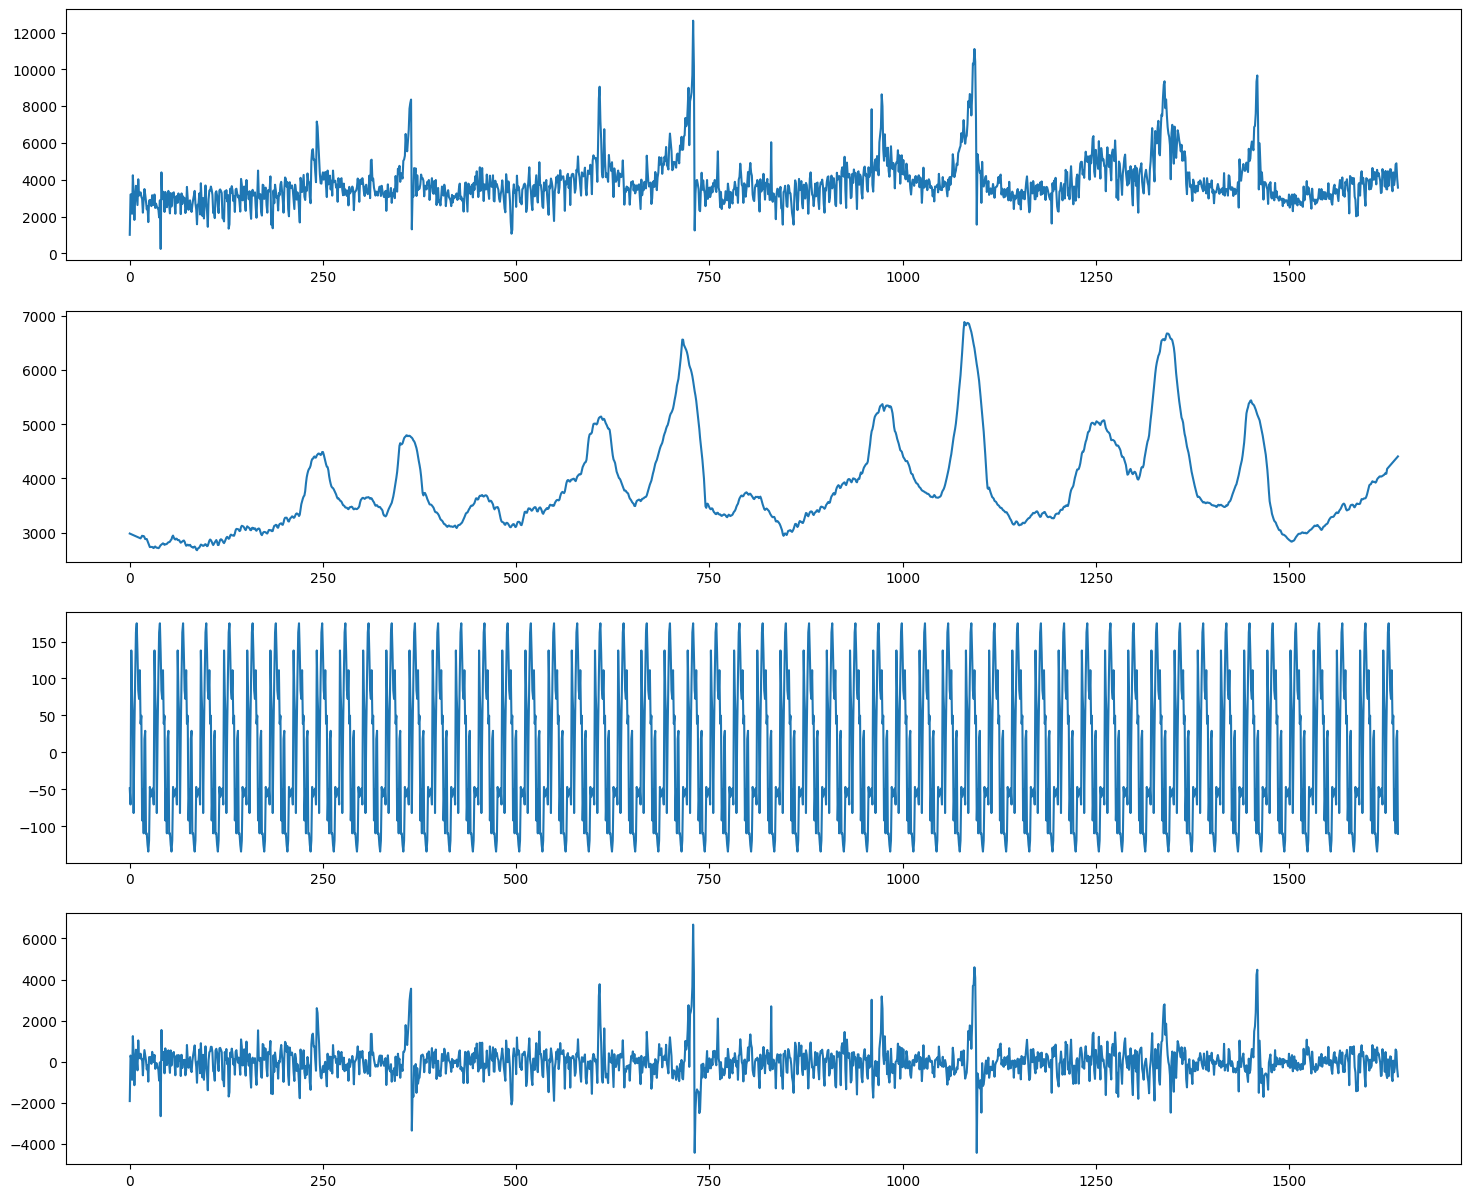

In [18]:
_, ax = plt.subplots(nrows=4, figsize=(18, 15))

result = statsmodels.tsa.seasonal.seasonal_decompose(train_c_df['series1'], period=30, extrapolate_trend='freq', model='additive')
result.observed.plot(ax=ax[0])
result.trend.plot(ax=ax[1])
result.seasonal.plot(ax=ax[2])
result.resid.plot(ax=ax[3])

<AxesSubplot:>

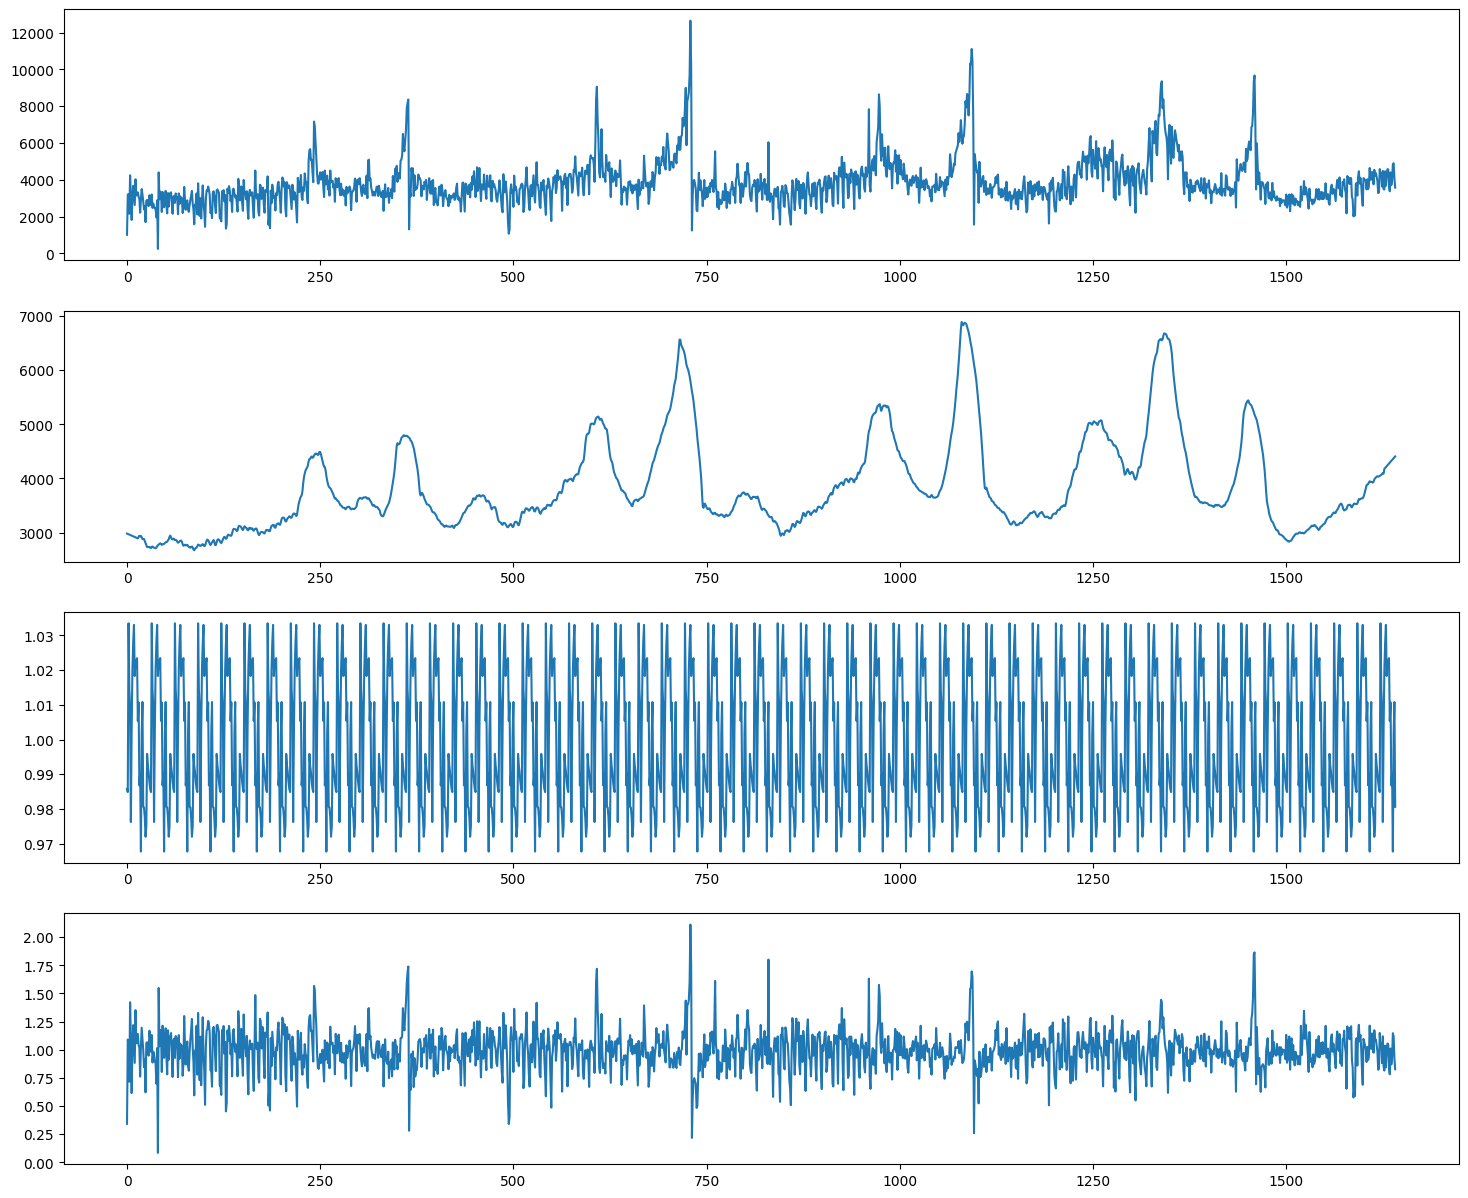

In [21]:
_, ax = plt.subplots(nrows=4, figsize=(18, 15))

result = statsmodels.tsa.seasonal.seasonal_decompose(train_c_df['series1'], period=30, extrapolate_trend='freq', model='multiplicative')
result.observed.plot(ax=ax[0])
result.trend.plot(ax=ax[1])
result.seasonal.plot(ax=ax[2])
result.resid.plot(ax=ax[3])

### Stationarity tests

In [25]:
adf_result = adfuller(train_c_df['series1'])
print("P value (adfuller): ", adf_result[1])

p value:  2.1154012725976072e-06


In [27]:
kpss_result = kpss(train_c_df['series1'])
print("P value (kpss): ", kpss_result[1])

P value (kpss):  0.01


/home/kirill/projects/personal_projects/A1_10_22/venv/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2019: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


### Autocorrelataion / P. autocorrelation

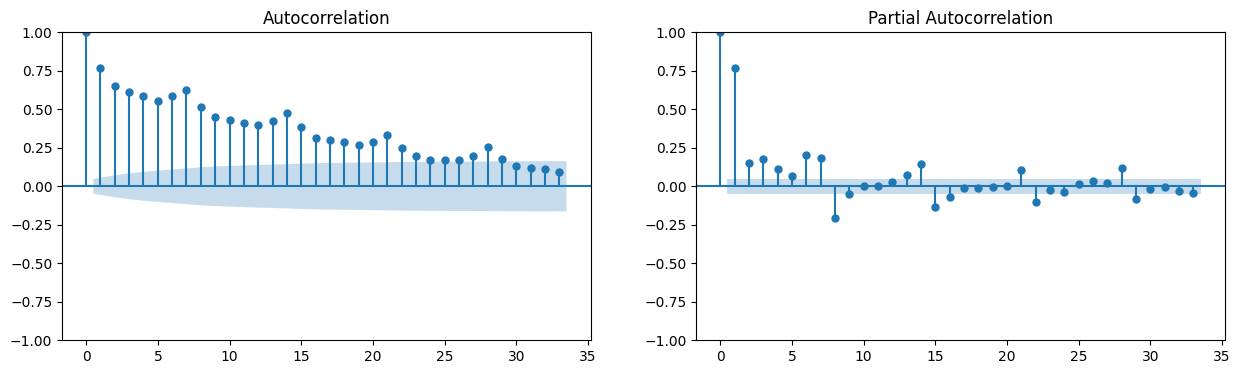

In [32]:
_, ax = plt.subplots(ncols=2, figsize=(15, 4))

_ = statsmodels.graphics.tsaplots.plot_acf(train_c_df['series1'], ax=ax[0])
_ = statsmodels.graphics.tsaplots.plot_pacf(train_c_df['series1'], ax=ax[1])

# Training, testing

In [34]:
PROJ_PATH = '/home/kirill/projects/personal_projects/A1_10_22/'
DATA_PATH = '/home/kirill/data/A1/'
csv_path = DATA_PATH + 'Задания_1_2.xlsx'

train_df = pd.read_excel(csv_path, sheet_name='Timeseries')

RAND_SEED = 42
SEED_EVERYTHING(RAND_SEED)

### ARIMA

In [10]:
order = (1, 0, 3)

train_part_end = '2018-09-01'
end = train_df.iloc[-1]['Date']
step_days = 90
test_size_days = 90

train_c_df = train_df.copy()
train_c_df['Date'] = pd.to_datetime(train_c_df['Date'])

n_iters = 1 + (((pd.to_datetime(end) - pd.to_datetime(train_part_end)).days - test_size_days) // step_days)
maes, rmses, mapes = [], [], []
for i in range(n_iters):
    td_step_days = i * step_days
    end_train = datetime.strptime(train_part_end, '%Y-%m-%d') + timedelta(days=(td_step_days))
    end_test = datetime.strptime(train_part_end, '%Y-%m-%d') + timedelta(days=(td_step_days + test_size_days))
    
    train_series = train_c_df[train_c_df['Date'] < end_train]
    test_series = train_c_df[(train_c_df['Date'] >= end_train) & (train_c_df['Date'] <= end_test)]
    
    arima_model = sm.tsa.arima.ARIMA(train_series['series1'], order=order)
    model = arima_model.fit()
    predicts = model.predict(start=test_series.index[0], end=test_series.index[-1])
    
    y_true = test_series['series1'].to_numpy()
    y_pred = predicts.to_numpy()
    
    rmses.append(mean_squared_error(y_true, y_pred, squared=True))
    maes.append(mean_absolute_error(y_true, y_pred))
    mapes.append(mean_absolute_percentage_error(y_true, y_pred))

rmse = np.array(rmses).mean()
mae = np.array(maes).mean()
mape = np.array(mapes).mean()

print(f"RMSE: {rmses}, mean: {rmse}")
print(f"MAE: {maes}, mean: {mae}")
print(f"MAPE: {mapes}, mean: {mape}")
    

RMSE: [853945.5776195144, 2201398.1451216396, 321190.6578696272], mean: 1125511.4602035938
MAE: [795.8701038713373, 1077.3665330405288, 431.1080516194274], mean: 768.1148961770978
MAPE: [0.2099795018242523, 0.26730099081549763, 0.14574528023763972], mean: 0.20767525762579653


<AxesSubplot:ylabel='series1'>

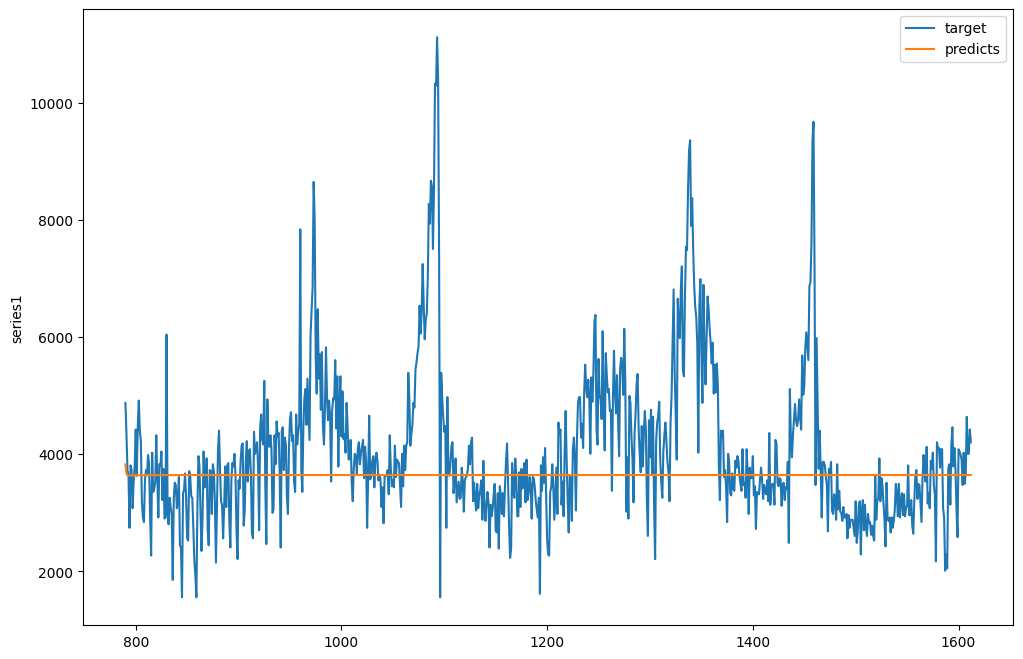

In [186]:
end_train = '2017-03-01'
end_test = '2019-06-01'
xtrain = train_c_df[train_c_df['Date'] < end_train]
xtest = train_c_df[(train_c_df['Date'] >= end_train) & (train_c_df['Date'] <= end_test)]

arima_model = sm.tsa.arima.ARIMA(xtrain['series1'], order=order)
model = arima_model.fit()
predicts = model.predict(start=xtest.index[0], end=xtest.index[-1])

_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(xtest['series1'], label='target')
sns.lineplot(predicts, label='predicts')

### ARIMA(auto arima)

In [102]:
fit_autoarima_params = train_c_df[train_c_df['Date'] < '2019-06-01']
model = auto_arima(fit_autoarima_params['series1'])
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1612
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -12920.871
Date:                Wed, 02 Nov 2022   AIC                          25857.742
Time:                        15:01:02   BIC                          25900.819
Sample:                             0   HQIC                         25873.732
                               - 1612                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.0942      9.018      0.232      0.816     -15.582      19.770
ar.L1          0.0164      0.028      0.586      0.558      -0.038       0.071
ar.L2         -0.7913      0.013    -62.728      0.0

In [9]:
order = (3, 1, 3)

train_part_end = '2018-09-01'
end = train_df.iloc[-1]['Date']
step_days = 90
test_size_days = 90

train_c_df = train_df.copy()
train_c_df['Date'] = pd.to_datetime(train_c_df['Date'])

n_iters = 1 + (((pd.to_datetime(end) - pd.to_datetime(train_part_end)).days - test_size_days) // step_days)
maes, rmses, mapes = [], [], []
for i in range(n_iters):
    td_step_days = i * step_days
    end_train = datetime.strptime(train_part_end, '%Y-%m-%d') + timedelta(days=(td_step_days))
    end_test = datetime.strptime(train_part_end, '%Y-%m-%d') + timedelta(days=(td_step_days + test_size_days))
    
    train_series = train_c_df[train_c_df['Date'] < end_train]
    test_series = train_c_df[(train_c_df['Date'] >= end_train) & (train_c_df['Date'] <= end_test)]
    
    arima_model = sm.tsa.arima.ARIMA(train_series['series1'], order=order)
    model = arima_model.fit()
    predicts = model.predict(start=test_series.index[0], end=test_series.index[-1])
    
    y_true = test_series['series1'].to_numpy()
    y_pred = predicts.to_numpy()
    
    rmses.append(mean_squared_error(y_true, y_pred, squared=True))
    maes.append(mean_absolute_error(y_true, y_pred))
    mapes.append(mean_absolute_percentage_error(y_true, y_pred))

rmse = np.array(rmses).mean()
mae = np.array(maes).mean()
mape = np.array(mapes).mean()

print(f"RMSE: {rmses}, mean: {rmse}")
print(f"MAE: {maes}, mean: {mae}")
print(f"MAPE: {mapes}, mean: {mape}")
    

RMSE: [7760400.141108178, 2237207.9211285706, 783268.7821236989], mean: 3593625.6147868163
MAE: [2541.949605587937, 985.5799047710751, 755.6384745304846], mean: 1427.7226616298324
MAPE: [0.6930562114201954, 0.22318136389556056, 0.21070658304343293], mean: 0.3756480527863963


<AxesSubplot:ylabel='series1'>

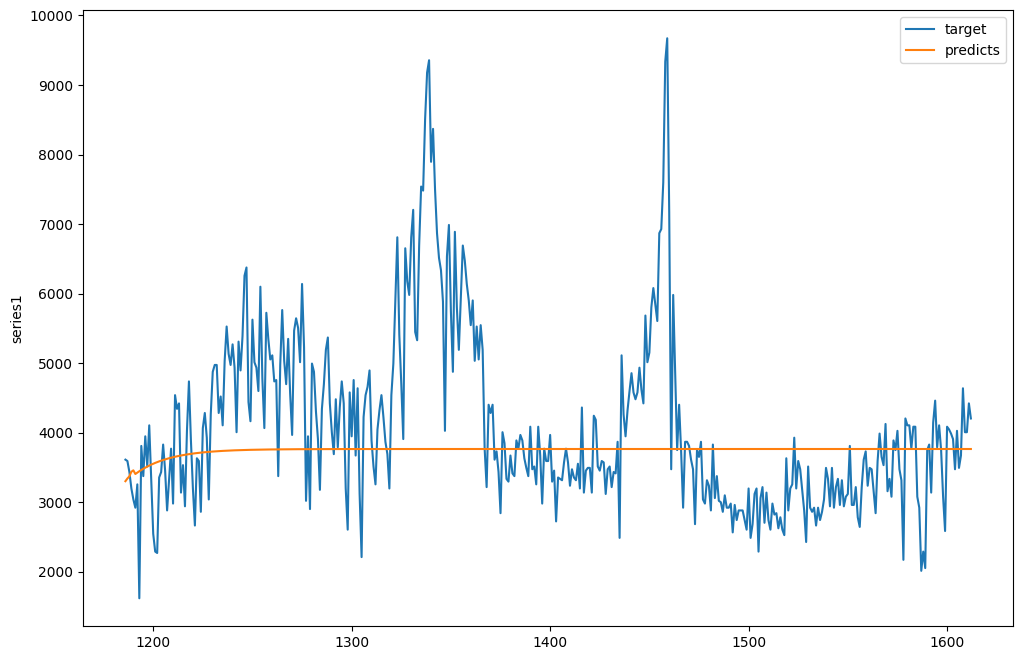

In [128]:
end_train = '2018-04-01'
end_test = '2019-06-01'
xtrain = train_c_df[train_c_df['Date'] < end_train]
xtest = train_c_df[(train_c_df['Date'] >= end_train) & (train_c_df['Date'] <= end_test)]

arima_model = sm.tsa.arima.ARIMA(xtrain['series1'], order=order)
model = arima_model.fit()
predicts = model.predict(start=xtest.index[0], end=xtest.index[-1])

_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(xtest['series1'], label='target')
sns.lineplot(predicts, label='predicts')

### Exponential smothing

In [13]:
train_part_end = '2018-09-01'
end = train_df.iloc[-1]['Date']
step_days = 90
test_size_days = 90

train_c_df = train_df.copy()
train_c_df['Date'] = pd.to_datetime(train_c_df['Date'])

n_iters = 1 + (((pd.to_datetime(end) - pd.to_datetime(train_part_end)).days - test_size_days) // step_days)
maes, rmses, mapes = [], [], []
for i in range(n_iters):
    td_step_days = i * step_days
    end_train = datetime.strptime(train_part_end, '%Y-%m-%d') + timedelta(days=(td_step_days))
    end_test = datetime.strptime(train_part_end, '%Y-%m-%d') + timedelta(days=(td_step_days + test_size_days))
    
    train_series = train_c_df[train_c_df['Date'] < end_train]
    test_series = train_c_df[(train_c_df['Date'] >= end_train) & (train_c_df['Date'] <= end_test)]
    
    arima_model = ExponentialSmoothing(train_series['series1'], use_boxcox=True)
    model = arima_model.fit()
    predicts = model.predict(start=test_series.index[0], end=test_series.index[-1])
    
    y_true = test_series['series1'].to_numpy()
    y_pred = predicts.to_numpy()
    
    rmses.append(mean_squared_error(y_true, y_pred, squared=True))
    maes.append(mean_absolute_error(y_true, y_pred))
    mapes.append(mean_absolute_percentage_error(y_true, y_pred))

rmse = np.array(rmses).mean()
mae = np.array(maes).mean()
mape = np.array(mapes).mean()

print(f"RMSE: {rmses}, mean: {rmse}")
print(f"MAE: {maes}, mean: {mae}")
print(f"MAPE: {mapes}, mean: {mape}")
    

RMSE: [11980729.135715252, 2231633.959541206, 778030.0627609341], mean: 4996797.71933913
MAE: [3233.946274903627, 984.337686037951, 754.3470084967558], mean: 1657.5436564794445
MAPE: [0.8700539052670915, 0.2221744974242323, 0.21035466538713468], mean: 0.4341943560261528


<AxesSubplot:ylabel='series1'>

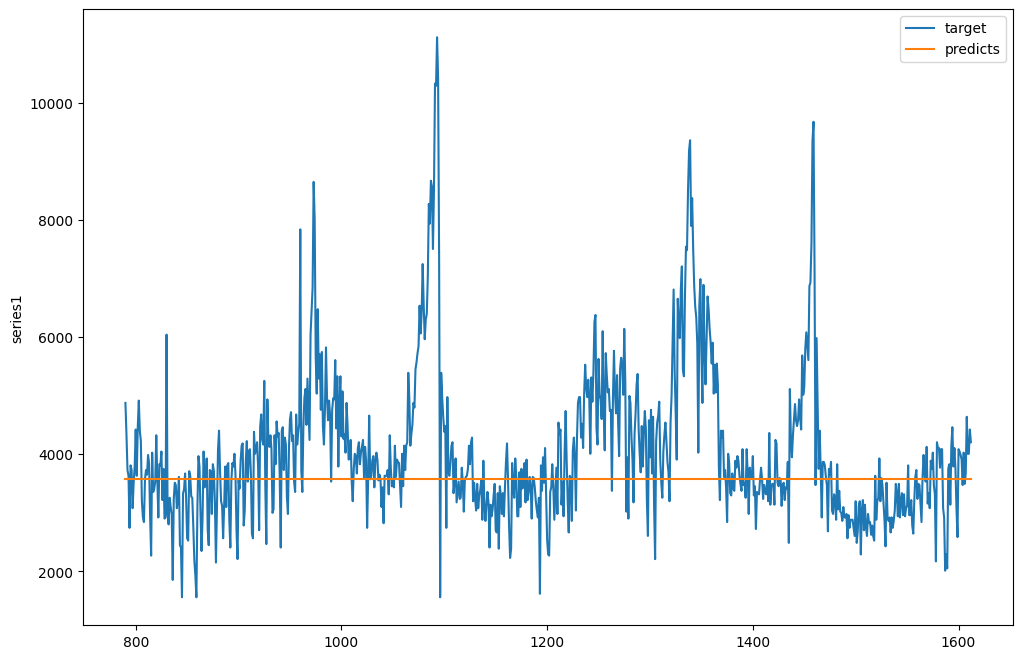

In [ ]:
end_train = '2017-03-01'
end_test = '2019-06-01'
xtrain = train_c_df[train_c_df['Date'] < end_train]
xtest = train_c_df[(train_c_df['Date'] >= end_train) & (train_c_df['Date'] <= end_test)]

arima_model = ExponentialSmoothing(xtrain['series1'], use_boxcox=True)
model = arima_model.fit()
predicts = model.predict(start=xtest.index[0], end=xtest.index[-1])

_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(xtest['series1'], label='target')
sns.lineplot(predicts, label='predicts')

### Prophet

In [12]:
train_part_end = '2018-09-01'
end = train_df.iloc[-1]['Date']
step_days = 90
test_size_days = 90

train_c_df = train_df.copy()
train_c_df['Date'] = pd.to_datetime(train_c_df['Date'])

n_iters = 1 + (((pd.to_datetime(end) - pd.to_datetime(train_part_end)).days - test_size_days) // step_days)
maes, rmses, mapes = [], [], []
for i in range(n_iters):
    td_step_days = i * step_days
    end_train = datetime.strptime(train_part_end, '%Y-%m-%d') + timedelta(days=(td_step_days))
    end_test = datetime.strptime(train_part_end, '%Y-%m-%d') + timedelta(days=(td_step_days + test_size_days))
    
    train_series = train_c_df[train_c_df['Date'] < end_train]
    train_series.columns = ['ds', 'y']
    test_series = train_c_df[(train_c_df['Date'] >= end_train) & (train_c_df['Date'] <= end_test)]
    
    m = Prophet()
    m.fit(train_series)
    
    predicts = m.predict(m.make_future_dataframe(periods=test_size_days + 1))
    predicts = predicts.iloc[-test_size_days-1:]
    
    y_true = test_series['series1'].to_numpy()
    y_pred = predicts['yhat'].to_numpy()
    
    print(y_pred.shape)
    print(y_true.shape)
    
    rmses.append(mean_squared_error(y_true, y_pred, squared=True))
    maes.append(mean_absolute_error(y_true, y_pred))
    mapes.append(mean_absolute_percentage_error(y_true, y_pred))

rmse = np.array(rmses).mean()
mae = np.array(maes).mean()
mape = np.array(mapes).mean()

print(f"RMSE: {rmses}, mean: {rmse}")
print(f"MAE: {maes}, mean: {mae}")
print(f"MAPE: {mapes}, mean: {mape}")
    

21:07:06 - cmdstanpy - INFO - Chain [1] start processing
21:07:06 - cmdstanpy - INFO - Chain [1] done processing
21:07:07 - cmdstanpy - INFO - Chain [1] start processing
21:07:07 - cmdstanpy - INFO - Chain [1] done processing


(91,)
(91,)


21:07:08 - cmdstanpy - INFO - Chain [1] start processing


(91,)
(91,)


21:07:08 - cmdstanpy - INFO - Chain [1] done processing


(91,)
(91,)
RMSE: [1446628.149688892, 1929026.2078059176, 364962.18376288336], mean: 1246872.180419231
MAE: [1059.1075037888797, 1199.1748374121937, 492.5619698873124], mean: 916.9481036961287
MAPE: [0.2702018805119817, 0.33422174882687167, 0.14650076098752635], mean: 0.25030813010879327


16:09:42 - cmdstanpy - INFO - Chain [1] start processing
16:09:42 - cmdstanpy - INFO - Chain [1] done processing


<AxesSubplot:ylabel='series1'>

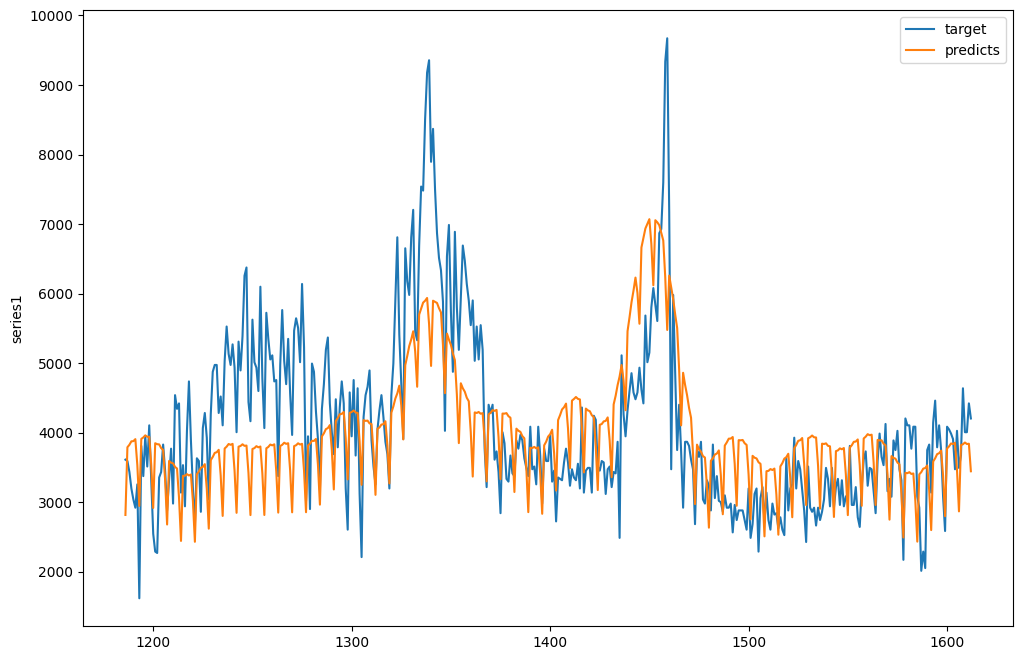

In [187]:
end_train = '2018-04-01'
end_test = '2019-06-01'
xtrain = train_c_df[train_c_df['Date'] < end_train]
xtrain.columns = ['ds', 'y']
xtest = train_c_df[(train_c_df['Date'] >= end_train) & (train_c_df['Date'] <= end_test)]
tst_size = (pd.to_datetime(end_test) - pd.to_datetime(end_train)).days

m = Prophet()
m.fit(xtrain)
predicts = m.predict(m.make_future_dataframe(tst_size + 1))
predicts = predicts.iloc[-tst_size-1:]

_, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(xtest['series1'], label='target')
sns.lineplot(predicts['yhat'], label='predicts')

#### Submit

In [24]:
SAVE_PATH = PROJ_PATH + 'data/task1_predicts.csv'
days_to_predict = 90

xtrain = train_df.copy()
xtrain.columns = ['ds', 'y']

m = Prophet()
m.fit(xtrain)
    
predicts = m.predict(m.make_future_dataframe(periods=days_to_predict))
predicts = predicts.iloc[-days_to_predict:]
predicts = predicts[['ds', 'yhat']]
predicts.columns = ['Date', 'series1']
predicts.to_csv(SAVE_PATH, index=False)

21:26:14 - cmdstanpy - INFO - Chain [1] start processing
21:26:14 - cmdstanpy - INFO - Chain [1] done processing
